In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
%matplotlib inline

In [3]:
### 1. Fetch historical stock price of Apple Inc. (AAPL)

data = yf.download("AAPL", start="2020-01-01", end="2025-01-01", interval="1d")

[*********************100%***********************]  1 of 1 completed


In [4]:
### SPY data
spy = yf.download("SPY", start="2020-01-01", end="2025-01-01", interval="1d")

[*********************100%***********************]  1 of 1 completed


In [5]:
spy['Lag_1'] = spy['Close'].pct_change(1)

In [6]:
### 2. Feature construction 
df = data[['Close']].copy()

In [7]:
### Feature 1 - Calculate return as 
for i in range(1,6):
    df[f'Lag_{i}'] = df['Close'].pct_change(i)

### Feature 2 - Rolling std
df['Volatility'] = df['Close'].pct_change().rolling(5).std()

### Feature 3 - average distance (Price / SMA_20 - 1)
df['MA_Dist'] = df['Close'] / df['Close'].rolling(20).mean() - 1

In [16]:
### Feature 4 - RSI
delta = df['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rsi = gain / loss
df["RSI"] = 100 - (100/(1+rsi))

In [8]:
### 3. Label
# If close price: tomorrow > today, set 1 (up), else set 0 (down)
# .shift(-1) is required, moving tomorrow rows to today rows as reference
df['Target'] = np.where(df['Close'].shift(-1) > df["Close"], 1, 0)

In [9]:
df['SPY_Lag_1'] = spy['Lag_1']

In [10]:
### Data cleaning (remove NaN caused by rolling)
df.dropna(inplace=True)

In [11]:
### 4. Split dataset into Train and Test
# Financial data could not be shuffled randomly, it must be divided according to time
# First 80% data as Train set, rest as Test set
split = int(len(df) * 0.8)
train = df.iloc[:split]
test = df.iloc[split:]

In [12]:
features = [col for col in df.columns if col not in [("Close","AAPL"), ("Target","")]]
X_train, y_train = train[features], train['Target']
X_test, y_test = test[features], test['Target']

In [13]:
print(f"{len(X_train)} days in train, {len(test)} in test")

991 days in train, 248 in test


In [14]:
features

[('Lag_1', ''),
 ('Lag_2', ''),
 ('Lag_3', ''),
 ('Lag_4', ''),
 ('Lag_5', ''),
 ('Volatility', ''),
 ('MA_Dist', ''),
 ('SPY_Lag_1', '')]

In [15]:
### 5. Define model
# n_estimators=100, seed 100 trees
# min_samples_split=10, avoid overfiting with at least 10 samples in each leaf node
model = RandomForestClassifier(n_estimators=100, min_samples_split=10, random_state=42)
model.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",10
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metri

In [16]:
### 6. Evaluation
preds = model.predict(X_test)
acc = accuracy_score(y_test, preds)

print(f"Accuracy: {acc:.2%}")
print(f"\nClassification:")
print(classification_report(y_test, preds))

Accuracy: 56.85%

Classification:
              precision    recall  f1-score   support

           0       0.50      0.50      0.50       107
           1       0.62      0.62      0.62       141

    accuracy                           0.57       248
   macro avg       0.56      0.56      0.56       248
weighted avg       0.57      0.57      0.57       248



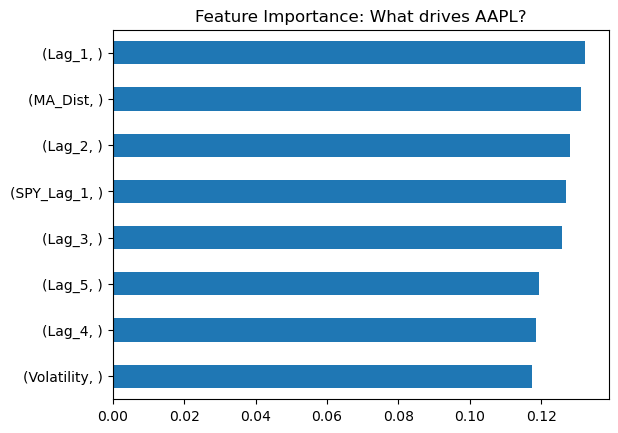

In [17]:
### 7. Feature importance
importances = pd.Series(model.feature_importances_, index=features)
importances.sort_values().plot(kind='barh', title="Feature Importance: What drives AAPL?")
plt.savefig("Figure_1_Feature_Importance_add_SPY.png", dpi=300, bbox_inches='tight')
plt.show()

In [18]:
### 8. Backtest
# If price goes up, we buy; if goes down, not execute
test_data = test.copy()
test_data['Prediction'] = preds
test_data.columns = test_data.columns.droplevel(1)

# .shift(-1) because predicted return is based on current prediction
test_data['Strategy_Return'] = test_data['Prediction'] * test_data["Close"].pct_change().shift(-1) 

# Cumulative Return
test_data['Cumulative_Strategy'] = (1 + test_data['Strategy_Return']).cumprod()
test_data['Cumulative_BuyHold'] = (1 + test_data['Close'].pct_change().shift(-1)).cumprod()


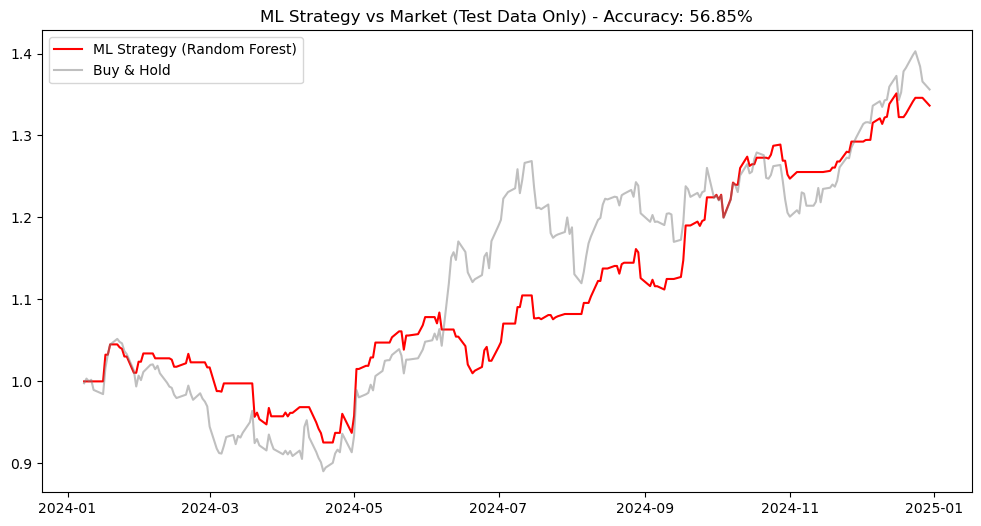

In [19]:

# Visualization
plt.figure(figsize=(12, 6))
plt.plot(test_data['Cumulative_Strategy'], label='ML Strategy (Random Forest)', color='red')
plt.plot(test_data['Cumulative_BuyHold'], label='Buy & Hold', color='grey', alpha=0.5)
plt.title(f"ML Strategy vs Market (Test Data Only) - Accuracy: {acc:.2%}")
plt.legend()
plt.savefig("Figure_2_ML_Strategy_vs_Market_(Test_Data_Only)_add_SPY.png", dpi=300, bbox_inches='tight')
plt.show()